## Notebook for searching bout in audio from SGL data using Kilosort


In [1]:
import socket
import os
import glob
import json
import shutil 
from typing import Union
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import subprocess
from datetime import timedelta
from importlib import reload

# pipeline imports
from pipefinch.h5tools.kwik import kutil
from pipefinch.pipeline import sglxutil as sglu


import logging

# Setup the logger
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')

ch = logging.StreamHandler()
ch.setLevel(logging.INFO)
ch.setFormatter(formatter)
logger.addHandler(ch)
        
logger.info('Logger set')
logger.info('Hostname {}'.format(socket.gethostname()))

2019-07-23 11:00:53,988 - root - INFO - Logger set
2019-07-23 11:00:53,989 - root - INFO - Hostname zpikezorter


### Session parameters and raw files

In [6]:
from pipefinch.pipeline import filestructure as et
reload(et)

# sess_par = {'bird': 'p14r14',
#            'sess': '2019-02-14_2250_01'}
# sess_par = {'bird': 'g3v3',
#            'sess': '110A2490R3800V_audiostimgood_g0',
#            'probe': 'probe_0', # probe to sort ('probe_0', 'probe_1') (to lookup in the rig_par which port to extract)
#            'sort': 1}

sess_par = {'bird': 'g4r4',
           'sess': '20190712_02',
           'probe': 'probe_0', # probe to sort ('probe_0', 'probe_1') (to lookup in the rig_par which port to extract)
           'sort': 1}

exp_struct = et.get_exp_struct(sess_par['bird'], sess_par['sess'], sess_par['sort'])

sort_params = {'adjacency_radius': -1,
              'detect_threshold': 2,
              'freq_min': 600}

ds_params = {'detect_sign': -1}

ks_params = {'use_gpu': 1,
            'auto_merge': 1,
            'filt_per_chan': 4,
            }

# convenient paths
kwik_folder = exp_struct['folders']['kwik']
ksort_folder = exp_struct['folders']['ksort']
raw_folder = exp_struct['folders']['raw']

In [7]:
exp_struct

{'folders': {'raw': '/mnt/microdrive/birds/g4r4/Ephys/raw/20190712_02',
  'kwik': '/data/experiment/microdrive/g4r4/Ephys/kwik/20190712_02',
  'msort': '/data/experiment/microdrive/g4r4/Ephys/msort/20190712_02',
  'ksort': '/data/experiment/microdrive/g4r4/Ephys/ksort/20190712_02'},
 'files': {'par': '/data/experiment/microdrive/g4r4/Ephys/ksort/20190712_02/params.json',
  'set': '/mnt/microdrive/birds/g4r4/Ephys/raw/20190712_02/settings.isf',
  'rig': '/mnt/microdrive/birds/g4r4/Ephys/raw/20190712_02/rig.json',
  'kwd': '/data/experiment/microdrive/g4r4/Ephys/kwik/20190712_02/streams.kwd',
  'kwik': '/data/experiment/microdrive/g4r4/Ephys/kwik/20190712_02/sort_1/spikes.kwik',
  'kwe': '/data/experiment/microdrive/g4r4/Ephys/kwik/20190712_02/events.kwe',
  'mda_raw': '/data/experiment/microdrive/g4r4/Ephys/msort/20190712_02/raw.mda',
  'bin_raw': '/data/experiment/microdrive/g4r4/Ephys/ksort/20190712_02/raw.bin'}}

#### get the spikeglx folder/file structure

In [8]:
# in zpike
sess_folder = exp_struct['folders']['raw']
#in lookfar
#sess_folder = '/Users/zeke/experiment/stimsim/Ephys/2019-05-27_stimsim_0000_00_g0'
all_probe_folders = glob.glob(os.path.join(sess_folder, '*'))
all_probe_folders

sgl_folder, sgl_pd = sglu.sgl_file_struct(sess_folder)
sgl_folder

{'nidq': '/mnt/microdrive/birds/g4r4/Ephys/raw/20190712_02',
 'imec': {0: '/mnt/microdrive/birds/g4r4/Ephys/raw/20190712_02/20190712_02_g0_imec0'}}

##### get the AP files for one imec probe

The imec file.

Here's the meaning of some of the metadata https://github.com/JaneliaSciComp/JRCLUST/wiki/.meta-file. In particular, there is an explanation of what channels in the probe are used and where they are located in the block. More detailed meta here https://github.com/billkarsh/SpikeGLX/blob/master/Markdown/Metadata.md.


In [9]:
probe_id = int(sess_par['probe'].split('_')[-1])

probe_data_folder = sgl_folder['imec'][probe_id]
probe_data_folder
ap_meta_files = glob.glob(os.path.join(probe_data_folder, '*.ap.meta'))

ap_meta_files[0]

'/mnt/microdrive/birds/g4r4/Ephys/raw/20190712_02/20190712_02_g0_imec0/20190712_02_g0_t0.imec0.ap.meta'

#### read a probe file and its meta

In [10]:
imec_meta_file_path = ap_meta_files[0]
# these should come from the .meta file
imec_meta_dict = sglu.get_imec_meta(imec_meta_file_path)

imec0 = sglu.get_imec_data(imec_meta_file_path)
n_chan = imec_meta_dict['nsavedchans'] #nSavedChans in meta file
s_f = imec0['meta']['s_f'] #30000.533148 #imSampleRate in meta file


In [55]:
imec0

{'meta': {'nsavedchans': 385, 's_f': 30000.0},
 't_ms': array([0.00000000e+00, 3.33333333e-02, 6.66666667e-02, ...,
        3.58984027e+06, 3.58984030e+06, 3.58984033e+06]),
 'neural': memmap([[ 19,  11,  11, ...,   4,   3,  -8],
         [-33, -34, -46, ..., -40, -43, -41],
         [ 33,  25,  23, ...,   4,  -3, -11],
         ...,
         [ -6,  -8, -10, ..., -29, -27, -18],
         [ 22,  27,  28, ...,   1,   3,  12],
         [ 64,  64,  64, ...,  64,  64,  64]], dtype=int16),
 'syn': memmap([64, 64, 64, ..., 64, 64, 64], dtype=int16),
 'only_neural': memmap([[ 19,  11,  11, ...,   4,   3,  -8],
         [-33, -34, -46, ..., -40, -43, -41],
         [ 33,  25,  23, ...,   4,  -3, -11],
         ...,
         [ 11,   3,   9, ...,  -8, -11,  -7],
         [ -6,  -8, -10, ..., -29, -27, -18],
         [ 22,  27,  28, ...,   1,   3,  12]], dtype=int16)}

#### get rid of the sync channel

In [11]:
imec0['only_neural'] = imec0['neural'][:384, :]
imec0['only_neural'].shape
n_chan = imec0['only_neural'].shape[0]

## get the adc data

In [28]:
nidq

{'meta': {'nsavedchans': 9,
  's_f': 20000.190251,
  'sns_mn_ma_xa_dw': [0, 0, 8, 1]},
 't_ms': array([0.00000000e+00, 4.99995244e-02, 9.99990488e-02, ...,
        3.58980110e+06, 3.58980115e+06, 3.58980120e+06]),
 'adc': memmap([[  92,   86,   95, ...,  164,  146,  156],
         [ 181,  181,  181, ...,  172,  173,  172],
         [  99,  101,  100, ...,  105,  103,  105],
         ...,
         [-386, -364, -341, ..., -246, -269, -291],
         [-735, -719, -700, ..., -259, -277, -295],
         [-594, -582, -570, ...,   95,   83,   68]], dtype=int16),
 'din': array([[1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)}

In [53]:
nidq['adc'].shape

(8, 71796708)

In [18]:
ni_meta_list = glob.glob(os.path.join(sgl_folder['nidq'], '*.meta'))

In [37]:
full_meta = dict(cfg['root'])

In [38]:
full_meta.update(nidq['meta'])

In [54]:
full_meta

{'acqmnmaxadw': '0,0,8,1',
 'appversion': '20190327',
 'filecreatetime': '2019-07-12T10:38:19',
 'filename': 'E:/data/birds/g4r4/Ephys/raw/20190712_02/20190712_02_g0/20190712_02_g0_t0.nidq.bin',
 'filesha1': '6EECF0A74F7799914FD08EAB54E61B7C601CFD00',
 'filesizebytes': '1292340744',
 'filetimesecs': '3589.801251836102',
 'firstsample': '1880402',
 'gatemode': 'Immediate',
 'nsavedchans': 9,
 'niairangemax': '5',
 'niairangemin': '-5',
 'niaitermination': 'Default',
 'niclockline1': 'Internal',
 'niclocksource': 'PXI1Slot3_8ch_Int : 20000.000000',
 'nidev1': 'PXI1Slot3',
 'nidev1productname': 'PXI-6221',
 'nimachans1': '',
 'nimagain': '1',
 'nimnchans1': '',
 'nimngain': '200',
 'nimuxfactor': '32',
 'nisamprate': '20000.190251',
 'nistartenable': 'false',
 'nistartline': 'PXI1Slot3/port0/line0',
 'nixachans1': '0:7',
 'nixdbytes1': '1',
 'nixdchans1': '0:7',
 'snsmnmaxadw': '0,0,8,1',
 'snssavechansubset': 'all',
 'syncnichan': '0',
 'syncnichantype': '0',
 'syncnithresh': '1.1',
 'sy

In [33]:
cfg = sglu.read_headless_config(ni_meta_list[0])
list(cfg['root'].keys())

['acqmnmaxadw',
 'appversion',
 'filecreatetime',
 'filename',
 'filesha1',
 'filesizebytes',
 'filetimesecs',
 'firstsample',
 'gatemode',
 'nsavedchans',
 'niairangemax',
 'niairangemin',
 'niaitermination',
 'niclockline1',
 'niclocksource',
 'nidev1',
 'nidev1productname',
 'nimachans1',
 'nimagain',
 'nimnchans1',
 'nimngain',
 'nimuxfactor',
 'nisamprate',
 'nistartenable',
 'nistartline',
 'nixachans1',
 'nixdbytes1',
 'nixdchans1',
 'snsmnmaxadw',
 'snssavechansubset',
 'syncnichan',
 'syncnichantype',
 'syncnithresh',
 'syncsourceidx',
 'syncsourceperiod',
 'trigmode',
 'typeimenabled',
 'typenienabled',
 'typethis',
 'usernotes',
 '~snschanmap',
 '~snsshankmap']

In [42]:
from datetime import datetime

In [46]:
date_string = cfg['root']['filecreatetime']
date_string

'2019-07-12T10:38:19'

In [52]:
date_string = cfg['root']['filecreatetime']
tstamp = datetime.strptime(date_string, '%Y-%m-%dT%H:%M:%S').strftime("%Y-%m-%d %H:%M:%S")

In [22]:
nidq = sglu.get_ni_data(ni_meta_list[0])
mic_data = nidq['adc'][0, :]

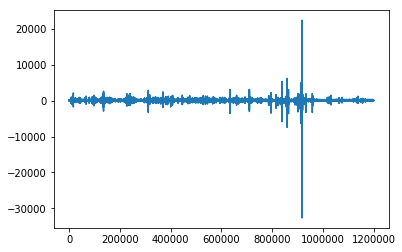

In [26]:
plt.plot(mic_data[:1200000])

In [40]:
cfg['root']['filecreatetime'].strftime("%Y-%m-%d %H:%M:%S").encode('utf-8')

AttributeError: 'str' object has no attribute 'strftime'

### Load the rig parameters and get the probe file, behavior trigers, etc
 - Get the rig par file
 - Get the aux channels
 - Detect onset of wav files

In [23]:
# do it

## Scripts for sorting with Kilosort
Steps involved:
 - Make binary file with selected recs, chans
 - Set kilosort parameters
 - Make kilosort chanmap
 - Make kilosort scripts and phy parameters file (for manual curation)
 - Run the kilosort scripts (via matlab)
 - Expose the paths for manual curation
 - After curation, make the kwik file with sorted data
 - Cleanup and move metadata to permanentt locations

### prep the files with their nice formats, locations and names


In [24]:
from pipefinch.neural.sort.kilo import core as ksc

In [25]:
reload(ksc)
ks_params = {'kilo_version': 1,
             'use_gpu': 1,
            'auto_merge': 1,
            'filt_per_chan': 4,
            's_f': int(s_f),
            'n_chan': n_chan}

In [26]:
exp_struct['folders']['ksort']

'/data/experiment/microdrive/g4r4/Ephys/ksort/20190712_02'

In [27]:
reload(ksc)
reload(probes)
file_paths, out_folder = ksc.make_paths(exp_struct['folders']['ksort'])

In [15]:
import shutil

In [16]:
file_paths

{'bin': '/data/experiment/microdrive/g4r4/Ephys/ksort/20190712_02/raw.bin',
 'params': '/data/experiment/microdrive/g4r4/Ephys/ksort/20190712_02/params.json',
 'prb': '/data/experiment/microdrive/g4r4/Ephys/ksort/20190712_02/chanMap.mat',
 'rez': '/data/experiment/microdrive/g4r4/Ephys/ksort/20190712_02/rez2.mat',
 'mat_log': '/data/experiment/microdrive/g4r4/Ephys/ksort/20190712_02/kilosort_mat.log',
 'phy_par': '/data/experiment/microdrive/g4r4/Ephys/ksort/20190712_02/params.py'}

In [ ]:
reload(ksc)
reload(probes)
file_paths, out_folder = ksc.make_paths(exp_struct['folders']['ksort'])
os.makedirs(out_folder, exist_ok=True)

# make the probe file
# for now, just copy copy the probe file from defaults to dict

shutil.copyfile('/home/ezequiel/repos/Kilosort2/configFiles/neuropixPhase3B2_kilosortChanMap.mat', file_paths['prb'])

# copy the binary file as the 'raw' binary file for the sorting
# this has to be done either way because /data partition is faster
# todo: concatenate them or something, from a kwd
logger.info('copying raw file into {}'.format(file_paths['bin']))
imec0['only_neural'].tofile(file_paths['bin'])

#shutil.copyfile(sglu.get_data_meta_path(imec_meta_file_path)[0], file_paths['bin'])

# parameters to pass to the msort scripts, other than de defaults
ks_params.update({'s_f': s_f, # required,
                  'n_chan': n_chan, # total number of chans in the .bin file,
                  'dtype_name': imec0['neural'].dtype.name
            })
ksc.make_kilo_scripts(exp_struct['folders']['ksort'], ks_params)
phy_pars = ksc.make_phy_par_file(ks_params, file_paths)

2019-07-23 10:26:23,235 - root - INFO - copying raw file into /data/experiment/microdrive/g4r4/Ephys/ksort/20190712_02/raw.bin


In [ ]:
file_paths

In [22]:
reload(ksc)
sort_result, sort_return_value = ksc.do_the_sort(file_paths)

2019-07-15 14:47:19,077 - pipefinch.neural.sort.kilo.core - INFO - Running kilosort on matlab
2019-07-15 14:47:19,078 - pipefinch.neural.sort.kilo.core - INFO - Sort folder is /data/experiment/microdrive/g4r4/Ephys/ksort/20190712_02
2019-07-15 14:47:19,079 - pipefinch.neural.sort.kilo.core - INFO - output to /data/experiment/microdrive/g4r4/Ephys/ksort/20190712_02/kilosort_mat.log


CalledProcessError: Command '['matlab', '-nodesktop', '-nosplash', '-noawt', '-r "cd(\'/data/experiment/microdrive/g4r4/Ephys/ksort/20190712_02\'); dir; run_master"', '-logfile /data/experiment/microdrive/g4r4/Ephys/ksort/20190712_02/kilosort_mat.log']' died with <Signals.SIGKILL: 9>.

In [ ]:
sort_return_value

In [26]:
sort_result

"\n                            < M A T L A B (R) >\n                  Copyright 1984-2019 The MathWorks, Inc.\n              R2019a Update 1 (9.6.0.1099231) 64-bit (glnxa64)\n                               April 12, 2019\n\n \nTo get started, type doc.\nFor product information, visit www.mathworks.com.\n \n\n.                         kilosort_mat.log          spike_templates.npy       \n..                        master.m                  spike_times.npy           \namplitudes.npy            params.py                 temp_wh.dat               \nchanMap.mat               pc_feature_ind.npy        template_feature_ind.npy  \nchannel_map.npy           pc_features.npy           template_features.npy     \nchannel_positions.npy     raw.bin                   templates.npy             \ncluster_Amplitude.tsv     rez.mat                   templates_ind.npy         \ncluster_ContamPct.tsv     run_master.m              whitening_mat.npy         \ncluster_KSLabel.tsv       similar_templates.npy   

In [26]:
file_paths

{'bin': '/data/experiment/microdrive/p14r14/Ephys/ksort/2019-02-15_3125_01/raw.bin',
 'params': '/data/experiment/microdrive/p14r14/Ephys/ksort/2019-02-15_3125_01/params.json',
 'prb': '/data/experiment/microdrive/p14r14/Ephys/ksort/2019-02-15_3125_01/chanMap.mat',
 'rez': '/data/experiment/microdrive/p14r14/Ephys/ksort/2019-02-15_3125_01/rez2.mat',
 'mat_log': '/data/experiment/microdrive/p14r14/Ephys/ksort/2019-02-15_3125_01/kilosort_mat.log',
 'phy_par': '/data/experiment/microdrive/p14r14/Ephys/ksort/2019-02-15_3125_01/params.py'}

## Command for viewing:
 - open up terminal with the environment msort
 - go go the ss_data folder for the session
 - run the command: qt-mountainview --raw raw.mda --filt sort_out/filt.mda.prv --pre sort_out/pre.mda.prv --samplerate=20000 --firings sort_out/firings.mda --cluster_metrics sort_out/cluster_metrics.json

# After manual curation
 - save the curated spikes in the sort_out/firings_curated.mda
 - come back to the notebook and run 

In [28]:
from pipefinch.h5tools.kwik import kwikfunctions as kwkf
reload(kwkf)
reload(et)

kwkf.kilo_to_kwik(exp_struct['files']['kwd'],
                 exp_struct['files']['kwik'],
                 exp_struct['folders']['ksort'],
                 rec_in_binary=selection_rec_list)


2019-05-21 15:42:14,162 - pipefinch.h5tools.kwik.kwikfunctions - INFO - Creating kwik file /data/experiment/microdrive/p14r14/Ephys/kwik/2019-02-15_3125_01/sort_1/spikes.kwik from kilosort folder /data/experiment/microdrive/p14r14/Ephys/ksort/2019-02-15_3125_01
2019-05-21 15:42:14,164 - pipefinch.h5tools.kwik.kwikfunctions - INFO - Found clu file, will attempt to unpack manual sorted data from kilosort
2019-05-21 15:42:14,171 - pipefinch.h5tools.kwik.kwikfunctions - INFO - Making spike tables
2019-05-21 15:42:14,361 - pipefinch.h5tools.kwik.kwikfunctions - INFO - Making rec tables (make_rec_groups)
2019-05-21 15:42:14,365 - pipefinch.h5tools.kwik.kwikfunctions - INFO - Making cluster group tables
2019-05-21 15:42:14,366 - pipefinch.h5tools.kwik.kwikfunctions - INFO - found cluster tags file in /data/experiment/microdrive/p14r14/Ephys/ksort/2019-02-15_3125_01/cluster_group.tsv
2019-05-21 15:42:14,368 - pipefinch.h5tools.kwik.kwikfunctions - INFO - Done


In [29]:
os.path.isfile('/data/experiment/microdrive/p14r14/Ephys/ksort/2019-02-15_3125_02/cluster_group.tsv')

True

In [31]:
### extract all unit waveforms
reload(kwkf)

from pipefinch.neural import units
reload(units)
units.get_all_unit_waveforms(exp_struct['files']['kwik'], exp_struct['files']['kwd'])

2019-05-21 15:42:28,359 - pipefinch.neural.units - INFO - About to get all waveforms for 3 units in file /data/experiment/microdrive/p14r14/Ephys/kwik/2019-02-15_3125_01/sort_1/spikes.kwik


0

In [ ]:
def msort_cleanup(exp_struct: dict):
    # remove the mda files and try to cleanup the msort temp location
    mda_raw_path = exp_struct['files']['mda_raw']
    logger.info('removing intermediate msort mda file {}'.format(mda_raw_path))
    os.remove(mda_raw_path)

def msort_tmp_clean():
    tmp_dir = os.path.abspath(os.environ['ML_TEMPORARY_DIRECTORY'])
    logger.info('Cleaning up msort temp dir {}'.format(tmp_dir))
    
#msort_tmp_clean()
msort_cleanup(exp_struct)

In [165]:
 exp_struct['files']

{'par': '/media/zinch/Windows/experiment/p14r14/ephys/msort/2019-02-13_1750_01/params.json',
 'set': '/mnt/zuperfinchjr/Data/p14r14/ephys/raw/2019-02-13_1750_01/settings.isf',
 'kwd': '/media/zinch/Windows/experiment/p14r14/ephys/kwik/2019-02-13_1750_01/streams.kwd',
 'kwik': '/media/zinch/Windows/experiment/p14r14/ephys/kwik/2019-02-13_1750_01/spikes.kwik',
 'kwe': '/media/zinch/Windows/experiment/p14r14/ephys/kwik/2019-02-13_1750_01/events.kwe',
 'mda_raw': '/media/zinch/Windows/experiment/p14r14/ephys/msort/2019-02-13_1750_01/raw.mda'}